# 📦 Amazon Product Review Sentiment Analysis (5-Class)

**This project performs sentiment classification of Amazon product reviews using TF-IDF + Ensemble learning.  Uniqueness is achieved through model ensembling, advanced visualizations, prediction sampling, and interpretability tools.**



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


**🔍 Exploratory Data Analysis**


In [2]:
df = pd.read_csv("/kaggle/input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv")  # Change if you're using a different file name
print(df.shape)
df.head()


(3000000, 3)


,class_index,review_title,review_text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


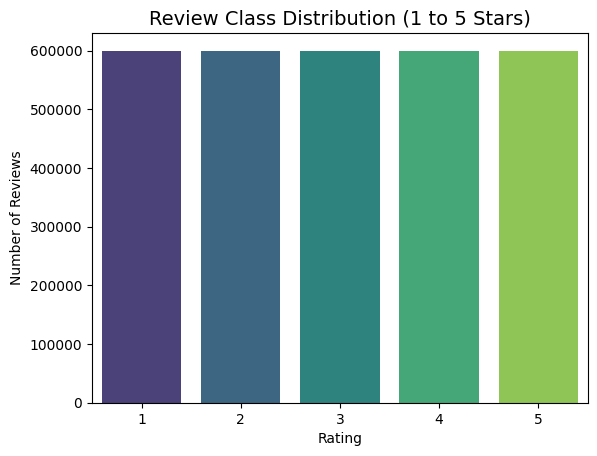

In [3]:
# Class Distribution Countplot
sns.countplot(x='class_index', data=df, palette='viridis')
plt.title("Review Class Distribution (1 to 5 Stars)", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()


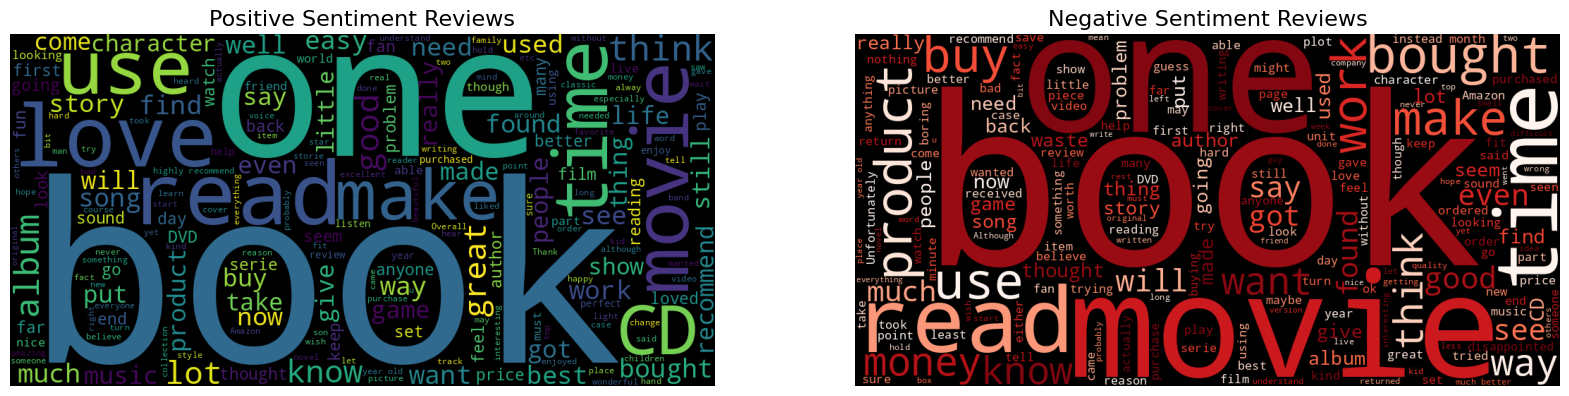

In [4]:
# WordClouds for Positive and Negative Reviews
positive_reviews = " ".join(df[df['class_index'] > 3]['review_text'].astype(str))
negative_reviews = " ".join(df[df['class_index'] < 3]['review_text'].astype(str))

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(WordCloud(width=1000, height=500).generate(positive_reviews))
axes[0].set_title("Positive Sentiment Reviews", fontsize=16)
axes[0].axis("off")

axes[1].imshow(WordCloud(width=1000, height=500, background_color='black', colormap='Reds').generate(negative_reviews))
axes[1].set_title("Negative Sentiment Reviews", fontsize=16)
axes[1].axis("off")

plt.show()


**🧹 Text Preprocessing & Feature Extraction**

In [5]:
X = df['review_text'].astype(str)
y = df['class_index']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


**🤖 Ensemble Model Training (Voting Classifier)**


In [ ]:
model1 = LogisticRegression(max_iter=1000)
model2 = MultinomialNB()
model3 = RandomForestClassifier(n_estimators=100, random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('lr', model1),
    ('nb', model2),
    ('rf', model3)
], voting='soft')

ensemble_model.fit(X_train_tfidf, y_train)

In [ ]:
y_pred = ensemble_model.predict(X_test_tfidf)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


**📈 Evaluation Metrics & Visualization**

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Data: {acc*100:.2f}%")


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1,2,3,4,5])
labels = [1, 2, 3, 4, 5]

metrics_df = pd.DataFrame({
    'Label': labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

metrics_df.set_index('class_index').plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Precision, Recall, F1-Score by Label")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.show()


In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Sample Predictions (with actual vs predicted)**



In [ ]:
# Display 10 random predictions
sample_df = X_test.sample(10, random_state=42).to_frame()
sample_df['Actual Label'] = y_test.loc[sample_df.index]
sample_df['Predicted Label'] = ensemble_model.predict(tfidf.transform(sample_df['text']))

# Visual format
for i in range(10):
    print(f"Review {i+1}:")
    print("Text:", sample_df.iloc[i]['text'][:300], "...")
    print("Actual Label:", sample_df.iloc[i]['Actual Label'])
    print("Predicted Label:", sample_df.iloc[i]['Predicted Label'])
    print("-" * 80)


**Save Model & Vectorizer**

In [ ]:
import joblib

joblib.dump(ensemble_model, "ensemble_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


In [ ]:
pred_counts = pd.Series(y_pred).value_counts().sort_index()
plt.pie(pred_counts, labels=[1,2,3,4,5], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Predicted Label Distribution")
plt.axis('equal')
plt.show()
